# PART 1

#### Libraries

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1006)>


False

In [2]:

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import pandas as pd
import collections
from numpy import linalg as la
import matplotlib.pyplot as plt
import re


#### Load data into memory


In [70]:
docs_path = 'data/farmers-protest-tweets.json'

In [71]:
original_data_tweets = pd.read_json(docs_path, lines=True)
print("The number of tweets in the dataset is: ", len(original_data_tweets))

The number of tweets in the dataset is:  117407


In [72]:
original_data_tweets.head()

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/ArjunSinghPanam/status/136...,2021-02-24 09:23:35+00:00,The world progresses while the Indian police a...,The world progresses while the Indian police a...,1364506249291784198,"{'username': 'ArjunSinghPanam', 'displayname':...",[https://twitter.com/ravisinghka/status/136415...,[https://t.co/es3kn0IQAF],0,0,...,0,1364506249291784198,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,{'url': 'https://twitter.com/RaviSinghKA/statu...,"[{'username': 'narendramodi', 'displayname': '..."
1,https://twitter.com/PrdeepNain/status/13645062...,2021-02-24 09:23:32+00:00,#FarmersProtest \n#ModiIgnoringFarmersDeaths \...,#FarmersProtest \n#ModiIgnoringFarmersDeaths \...,1364506237451313155,"{'username': 'PrdeepNain', 'displayname': 'Pra...",[],[],0,0,...,0,1364506237451313155,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,[{'thumbnailUrl': 'https://pbs.twimg.com/ext_t...,NaN,None,"[{'username': 'Kisanektamorcha', 'displayname'..."
2,https://twitter.com/parmarmaninder/status/1364...,2021-02-24 09:23:22+00:00,ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇ...,ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇ...,1364506195453767680,"{'username': 'parmarmaninder', 'displayname': ...",[],[],0,0,...,0,1364506195453767680,pa,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,None,NaN,None,None
3,https://twitter.com/anmoldhaliwal/status/13645...,2021-02-24 09:23:16+00:00,@ReallySwara @rohini_sgh watch full video here...,@ReallySwara @rohini_sgh watch full video here...,1364506167226032128,"{'username': 'anmoldhaliwal', 'displayname': '...",[https://youtu.be/-bUKumwq-J8],[https://t.co/wBPNdJdB0n],0,0,...,0,1364350947099484160,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'thumbnailUrl': 'https://pbs.twimg.com/ext_t...,NaN,None,"[{'username': 'ReallySwara', 'displayname': 'S..."
4,https://twitter.com/KotiaPreet/status/13645061...,2021-02-24 09:23:10+00:00,#KisanEktaMorcha #FarmersProtest #NoFarmersNoF...,#KisanEktaMorcha #FarmersProtest #NoFarmersNoF...,1364506144002088963,"{'username': 'KotiaPreet', 'displayname': 'Pre...",[],[],0,0,...,0,1364506144002088963,und,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,None


#### Extract fields Tweet | Date | Hashtags| Likes | Retweets | Url


In [73]:
data_tweets = original_data_tweets
data_tweets.rename(columns={
    'content': 'Tweet',
    'date': 'Date',
    'likeCount': 'Likes',
    'retweetCount': 'Retweets',
    'url': 'Url',
    'lang': 'Language'
}, inplace=True)

data_tweets['Hashtags'] = data_tweets['Tweet'].apply(lambda x: [i for i in x.split() if i.startswith("#")]) # add a column for hashtags

data_tweets.head()

,Url,Date,Tweet,renderedContent,id,user,outlinks,tcooutlinks,replyCount,Retweets,...,conversationId,Language,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,Hashtags
0,https://twitter.com/ArjunSinghPanam/status/136...,2021-02-24 09:23:35+00:00,The world progresses while the Indian police a...,The world progresses while the Indian police a...,1364506249291784198,"{'username': 'ArjunSinghPanam', 'displayname':...",[https://twitter.com/ravisinghka/status/136415...,[https://t.co/es3kn0IQAF],0,0,...,1364506249291784198,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,{'url': 'https://twitter.com/RaviSinghKA/statu...,"[{'username': 'narendramodi', 'displayname': '...","[#ModiDontSellFarmers, #FarmersProtest, #FreeN..."
1,https://twitter.com/PrdeepNain/status/13645062...,2021-02-24 09:23:32+00:00,#FarmersProtest \n#ModiIgnoringFarmersDeaths \...,#FarmersProtest \n#ModiIgnoringFarmersDeaths \...,1364506237451313155,"{'username': 'PrdeepNain', 'displayname': 'Pra...",[],[],0,0,...,1364506237451313155,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,[{'thumbnailUrl': 'https://pbs.twimg.com/ext_t...,NaN,None,"[{'username': 'Kisanektamorcha', 'displayname'...","[#FarmersProtest, #ModiIgnoringFarmersDeaths, ..."
2,https://twitter.com/parmarmaninder/status/1364...,2021-02-24 09:23:22+00:00,ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇ...,ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇ...,1364506195453767680,"{'username': 'parmarmaninder', 'displayname': ...",[],[],0,0,...,1364506195453767680,pa,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,None,NaN,None,None,[#FarmersProtest]
3,https://twitter.com/anmoldhaliwal/status/13645...,2021-02-24 09:23:16+00:00,@ReallySwara @rohini_sgh watch full video here...,@ReallySwara @rohini_sgh watch full video here...,1364506167226032128,"{'username': 'anmoldhaliwal', 'displayname': '...",[https://youtu.be/-bUKumwq-J8],[https://t.co/wBPNdJdB0n],0,0,...,1364350947099484160,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,[{'thumbnailUrl': 'https://pbs.twimg.com/ext_t...,NaN,None,"[{'username': 'ReallySwara', 'displayname': 'S...","[#farmersprotest, #NoFarmersNoFood]"
4,https://twitter.com/KotiaPreet/status/13645061...,2021-02-24 09:23:10+00:00,#KisanEktaMorcha #FarmersProtest #NoFarmersNoF...,#KisanEktaMorcha #FarmersProtest #NoFarmersNoF...,1364506144002088963,"{'username': 'KotiaPreet', 'displayname': 'Pre...",[],[],0,0,...,1364506144002088963,und,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,None,"[#KisanEktaMorcha, #FarmersProtest, #NoFarmers..."


Example of tweet

In [11]:
for i in range(1):
    print(data_tweets.iloc[i]['Tweet'])


The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. 

@narendramodi @DelhiPolice Shame on you. 

#ModiDontSellFarmers 
#FarmersProtest 
#FreeNodeepKaur https://t.co/es3kn0IQAF


**tweet_document_ids_map**

In [74]:
tweet_document_ids_map =  pd.read_csv("data/tweet_document_ids_map.csv")

In [75]:
tweet_document_ids_map.head()

,docId,id
0,doc_0,1364506249291784198
1,doc_1,1364506237451313155
2,doc_2,1364506167226032128
3,doc_3,1364505991887347714
4,doc_4,1364505813834989568


In [76]:
document_id_map = dict(zip(tweet_document_ids_map['id'], tweet_document_ids_map['docId']))


#### Implement a language dictionary to process stop words depending on the language of the tweet

Given that we identified different languages among the tweets in the original data, we decided to apply stop words in the build_terms function according to their respective languages.

In [15]:
# these are the unique larnguages in the dataset
print(original_data_tweets['Language'].unique())

['en' 'pa' 'und' 'hi' 'ta' 'hu' 'ur' 'et' 'mr' 'tl' 'es' 'de' 'in' 'or'
 'kn' 'ml' 'ht' 'it' 'fr' 'bn' 'sv' 'tr' 'gu' 'te' 'da' 'pt' 'cs' 'sl'
 'nl' 'ca' 'no' 'cy' 'pl' 'eu' 'ne' 'ru' 'lv' 'lt' 'fi' 'ro' 'ar' 'fa'
 'vi' 'is' 'ja' 'si']


In [84]:
language_dict = {
    'ar': 'arabic',
    'eu': 'basque',
    'bn': 'bengali',
    'ca': 'catalan',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'fi': 'finnish',
    'fr': 'french',
    'de': 'german',
    'hu': 'hungarian',
    'in': 'indonesian',
    'it': 'italian',
    'ne': 'nepali',
    'no': 'norwegian',
    'pt': 'portuguese',
    'ro': 'romanian',
    'ru': 'russian',
    'es': 'spanish',
    'sv': 'swedish',
    'tr': 'turkish'
}

#### 1. Pre-process document

In [78]:
import string
def build_terms(line, lang):

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words(lang)) # get the stop words for the language

    line = re.sub(r'http\S+', '', line)
    words_line= line.split() # tokenize the text, get a list of terms

    #First we deal with # separation
    treated_words = []
    for word in words_line:

        if word and word[0] == "#":  #If its a hashtag
            separated_list = re.split(r'(?<=[a-z])(?=[A-Z])', word[1:])
            for separated_word in separated_list:
                treated_words.append(separated_word)
        else:
            treated_words.append(word)


    line = [word.lower() for word in treated_words] # everything to lowercase
    translator = str.maketrans('', '', string.punctuation)
    line = [word.translate(translator) for word in line]  # remove punctuation

    line= [word for word in line if word not in stop_words] # remove stop_words
    line= [stemmer.stem(word) for word in line ] # steam
    line = [word for word in line if word.isalnum()]  # keeps only words with alphanumeric characters

    return line

In [79]:
terms = build_terms("hello my #NameBrand is @john. I am a student, #student, ¢¢¢¢¢", 'english')
print(terms)

['hello', 'name', 'brand', 'john', 'student', 'student']


In [80]:
# input: dataset of tweets, output: preprocessed dataset of tweets
# output: dataframe for each tweet content - build terms (stop words depend on the language)
def preprocess_document(tweets):
    preprocessed_document = tweets.copy() # copy to avoid modifying the original dataset

    for i in range(len(preprocessed_document)):
        twt_content = preprocessed_document.iloc[i]['Tweet']

        if preprocessed_document.iloc[i]['Language'] in language_dict:
            lang = language_dict[preprocessed_document.iloc[i]['Language']]
        else:
            lang = 'english'

        preprocessed_document.at[i, 'Tweet'] = build_terms(twt_content, lang)


    preprocessed_document = preprocessed_document[['Tweet', 'Date', 'Hashtags', 'Likes', 'Retweets', 'Url']]

    return preprocessed_document


In [82]:
english_tweets_ids = data_tweets[data_tweets['Language'] == 'en']['id'].tolist()
print(english_tweets_ids)

[1364506249291784198, 1364506237451313155, 1364506167226032128, 1364505991887347714, 1364505813834989568, 1364505749359976448, 1364505676375076867, 1364505511073300481, 1364505452134817795, 1364505443997937669, 1364505314586951680, 1364505255946379268, 1364505170743238659, 1364505014530531330, 1364504850524995587, 1364504705460658179, 1364504358277308416, 1364504281618001921, 1364504256934408193, 1364503870651555840, 1364503539322671108, 1364503376885473282, 1364503314407124992, 1364503215232798721, 1364502921858211840, 1364502574280409091, 1364502520412930049, 1364502280167325699, 1364502000809824261, 1364501857788289027, 1364501716960354306, 1364500816418250752, 1364500655730274307, 1364500318420160513, 1364500256851951619, 1364500069945384961, 1364499897404190721, 1364499704147374082, 1364499669271855104, 1364499530515963905, 1364499513520525312, 1364499441927954434, 1364499308414967808, 1364498983813599235, 1364498954092642305, 1364498807157792770, 1364498674223513602, 136449864193

In [85]:
data_tweets = data_tweets[data_tweets['Language'] == 'en'].reset_index(drop=True)
data_tweets.head()
processed_tweets = preprocess_document(data_tweets)
processed_tweets.head()

,Tweet,Date,Hashtags,Likes,Retweets,Url
0,"[world, progress, indian, polic, govt, still, ...",2021-02-24 09:23:35+00:00,"[#ModiDontSellFarmers, #FarmersProtest, #FreeN...",0,0,https://twitter.com/ArjunSinghPanam/status/136...
1,"[farmer, protest, modi, ignor, farmer, death, ...",2021-02-24 09:23:32+00:00,"[#FarmersProtest, #ModiIgnoringFarmersDeaths, ...",0,0,https://twitter.com/PrdeepNain/status/13645062...
2,"[reallyswara, rohinisgh, watch, full, video, f...",2021-02-24 09:23:16+00:00,"[#farmersprotest, #NoFarmersNoFood]",0,0,https://twitter.com/anmoldhaliwal/status/13645...
3,"[mandeeppunia1, watch, full, video, farmerspro...",2021-02-24 09:22:34+00:00,"[#farmersprotest, #NoFarmersNoFood]",0,0,https://twitter.com/anmoldhaliwal/status/13645...
4,"[mandeeppunia1, watch, full, video, farmerspro...",2021-02-24 09:21:51+00:00,"[#farmersprotest, #NoFarmersNoFood]",0,0,https://twitter.com/anmoldhaliwal/status/13645...


#### 2. Exploratory data analysis

In [19]:
# input: dataset of tweets with the column 'Tweet' containing the preprocessed tweets
# output: list of lists of terms
def preprocess_tweets(lines):
      terms = []
      for line in lines:
         terms.append(line)
      return terms


In [20]:
all_tweets_in_terms = preprocess_tweets(processed_tweets['Tweet'])
print(all_tweets_in_terms[0])

['world', 'progress', 'indian', 'polic', 'govt', 'still', 'tri', 'take', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', 'modi', 'dont', 'sell', 'farmer', 'farmer', 'protest', 'free', 'nodeep', 'kaur']


Word counting distribution

In [21]:
def word_count_distribution(processed_tweets):
    all_words = [word for tweet in processed_tweets for word in tweet]
    word_count = collections.Counter(all_words)
    most_common_words = word_count.most_common(10)

    words, counts = zip(*most_common_words)
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.show()

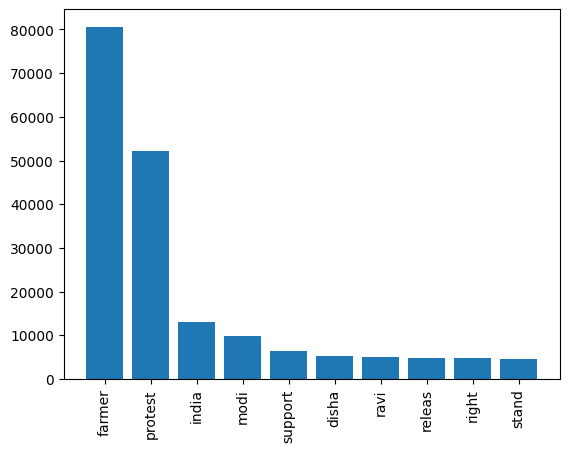

In [22]:
word_count_distribution(all_tweets_in_terms)

Average Sentence Length

In [23]:
def average_sentence_length(processed_tweets):
    lengths = [len(tweet) for tweet in processed_tweets]
    return sum(lengths) / len(lengths) if lengths else 0

In [24]:
average_sentence_length(all_tweets_in_terms)

16.673067789960562

Vocabulary size

In [25]:
def vocabulary_size(processed_terms):
    all_words = [word for tweet in processed_terms for word in tweet]
    return len(set(all_words))

In [26]:
vocabulary_size(all_tweets_in_terms)

36230

Ranking of the most retweeted tweets

In [27]:
def top_retweeted_tweets(data_tweets, top_n):
    # Sort by retweetCount in descending order and select the top N tweets
    top_retweets = data_tweets.sort_values(by='Retweets', ascending=False).head(top_n)
    
    # Extract relevant fields: content, retweet count, and tweet URL
    return top_retweets[['Tweet', 'Retweets', 'Url']]

In [28]:
top_retweeted_tweets(data_tweets, 10)

,Tweet,Retweets,Url
3203,There's a #FarmersProtest happening in Germany...,6164,https://twitter.com/dhruv_rathee/status/136414...
38410,"disha ravi, a 21-year-old climate activist, ha...",4673,https://twitter.com/rupikaur_/status/136088206...
38012,Disha Ravi broke down in court room and told j...,3742,https://twitter.com/amaanbali/status/136090860...
46206,Farmers are so sweet. Y’all have to see this @...,3332,https://twitter.com/jedijasmin_/status/1360162...
27071,india is targeting young women to silence diss...,3230,https://twitter.com/rupikaur_/status/136179092...
45142,Bollywood has betrayed Panjab &amp; the farmer...,3182,https://twitter.com/RaviSinghKA/status/1360260...
35993,"Please, where did you get your PhD from? Anti-...",2495,https://twitter.com/sushant_says/status/136103...
9846,This is Revolution. More than 2.25lac people a...,2258,https://twitter.com/amaanbali/status/136342152...
38262,Wish you fly over the Delhi border and look at...,2208,https://twitter.com/avinashkalla/status/136089...
41472,They went after our grandparents.\n#GurmukhSin...,1933,https://twitter.com/Monica_Gill1/status/136062...


Word Clouds for the Most Frequent Words

In [97]:
from wordcloud import WordCloud

def generate_word_clouds(all_tweets_in_terms):
    # Join all the tweets into a single string
    all_words = ' '.join([' '.join(tweet) for tweet in all_tweets_in_terms])
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes
    plt.show()

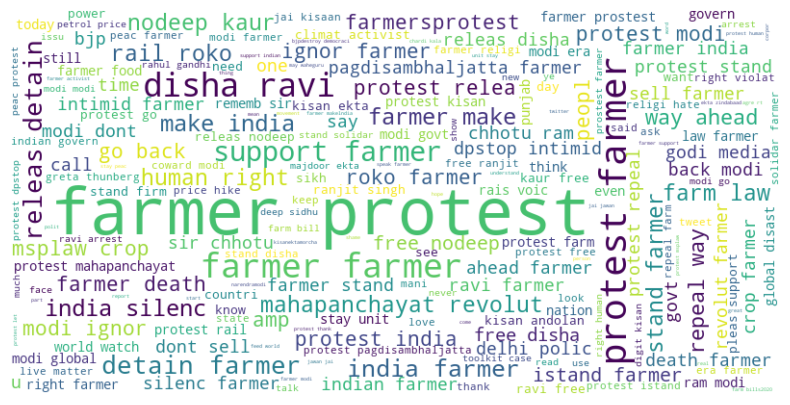

In [30]:
generate_word_clouds(all_tweets_in_terms)

Entity Recognition

In [31]:
import spacy
nlp = spacy.load("en_core_web_sm") #in case of not having it, download through command 'python -m spacy download en_core_web_sm'

In [32]:
def entity_recognition(data_tweets, tweet_id):

    ner_categories = ["PERSON", "ORG", "GPE"]

    doc = nlp(data_tweets[tweet_id])
    
    entities = []
    
    for ent in doc.ents:
        if ent.label_ in ner_categories:
            entities.append((ent.text, ent.label_))
    
    for entity, category in entities:
        print(f"{entity}: {category}")
    
    spacy.displacy.render(doc, style="ent")


In [33]:
entity_recognition(data_tweets['Tweet'], 0)

Govt: ORG
India: GPE


# PART 2

## Indexing

#### Build inverted index

The next step to build our search engine is to construct the inverted index using the TF-IDF algorithm. Initially, we implemented the **"create_index_tfidf"** function from a previous lab, but it was inefficient for larger datasets. We decided to optimize the code for better performance.

To address the performance issues, we restructured the function as follows:

In [96]:
from collections import defaultdict, Counter
from array import array
import numpy as np
import math


num_documents = len(document_id_map)

# create index, tf, df, and idf dictionaries
index = defaultdict(list)
tf = defaultdict(list)
df = defaultdict(int)
idf = defaultdict(float)

# Convert 'Tweet' column to a list of lists to speed up iteration
tweets = processed_tweets['Tweet'].tolist()

# Iterate over tweets and their document IDs
for i, tweet in enumerate(tweets):
    current_tweet_index = defaultdict(lambda: [document_id_map[english_tweets_ids[i]], array('I')]) 
    term_counts = Counter(tweet)  # Count term frequencies in the current tweet

    # Calculate normalized term frequencies and update current_tweet_index
    norm = math.sqrt(sum((count ** 2 for count in term_counts.values())))

    for position, term in enumerate(tweet):
        current_tweet_index[term][1].append(position) # Store position for term

    for term, (doc_id, positions) in current_tweet_index.items():
        # Calculate term frequency (TF)
        tf_value = len(positions) / norm
        tf[term].append(np.round(tf_value, 4))  

        # Update document frequency (DF)
        df[term] += 1

        # Update main index
        index[term].append([doc_id, positions])

# Calculate IDF for all terms
for term in df:
    idf[term] = np.round(np.log(float(num_documents) / df[term]), 4)


In [46]:
# The data structure for the index is as follows
# For each term -> document ids where the term appears + positions of the term in the document):
# {
#     term_id_1: [[doc_0, array('I', [0])]...[doc_n, array('I', [2])]],
#     term_id_2: [[doc_0, array('I', [1])]...[doc_n, array('I', [0, 3])]],
#     ...
# }
for term in list(index)[:5]:
    print(f"{term}: {index[term]}")

world: [['doc_0', array('I', [0])], ['doc_38', array('I', [11])], ['doc_52', array('I', [7])], ['doc_86', array('I', [6])], ['doc_111', array('I', [8])], ['doc_143', array('I', [0])], ['doc_187', array('I', [3])], ['doc_248', array('I', [16])], ['doc_252', array('I', [4])], ['doc_336', array('I', [9])], ['doc_394', array('I', [13, 15])], ['doc_460', array('I', [3, 4])], ['doc_508', array('I', [7])], ['doc_519', array('I', [22])], ['doc_689', array('I', [5])], ['doc_751', array('I', [11])], ['doc_913', array('I', [0])], ['doc_926', array('I', [5])], ['doc_997', array('I', [15])], ['doc_1057', array('I', [10])], ['doc_1059', array('I', [4])], ['doc_1066', array('I', [7])], ['doc_1093', array('I', [9])], ['doc_1159', array('I', [11])], ['doc_1262', array('I', [12])], ['doc_1346', array('I', [9])], ['doc_1377', array('I', [1])], ['doc_1451', array('I', [7])], ['doc_1479', array('I', [2])], ['doc_1502', array('I', [2])], ['doc_1538', array('I', [0])], ['doc_1563', array('I', [1])], ['doc_15

#### Proporse test queries

In [64]:
# define 5 queries to test the search engine
queries = [
    "Farmer protest",
    "Modi govt",
    "diesel price",
    "indian farmer",
    "Disha ravi"
]

#### Rank your results

In [90]:
# Represent the query as a weighted tf-idf vector
# Represent each document as a weighted tfidf vector
# Compute the cosine similarity score for the query vector and each document vector
# Rank documents with respect to the query by score
# Return the top K (e.g., K = 10) to the user

def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would become 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query
    query_norm = la.norm(list(query_terms_count.values())) # compute the norm of the tf vector

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index: # skip terms that are not in our index of terms
            continue

        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term] # compute the tf*idf
        # eg for the first query "Indian protest" the query_vector will be [0.5, 0.5]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, doc_positions) in enumerate(index[term]):
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term] # compute the tf*idf for the term in the doc

    # Calculate the score of each doc
    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)

    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        return []

    return result_docs

In [91]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = build_terms(query,'english')
    docs = set()
    i=0
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs = [posting[0] for posting in index[term]]

            if i == 0:
                docs = set(term_docs)
                i = 1
            #docs = docs intersection term_docs
            else: docs &= set(term_docs)

        except:
            #term is not in index
            pass

    docs = list(docs)

    ranked_docs = rank_documents(query, docs, index, idf, tf)

    #print( ranked_docs)
    return ranked_docs

In [72]:
all_ranked_docs = []
for query in queries:
    ranked_docs = search_tf_idf(query, index)
    all_ranked_docs.append(ranked_docs)
    print("\n======================\nTop 5 results out of {} for the searched query: {}\n".format(len(ranked_docs), query))
    for d_id in ranked_docs[:5]:
        print("doc_id = {} ".format(d_id))


Top 5 results out of 45354 for the searched query: Farmer protest

doc_id = doc_32542 
doc_id = doc_22865 
doc_id = doc_7859 
doc_id = doc_6060 
doc_id = doc_5727 

Top 5 results out of 855 for the searched query: Modi govt

doc_id = doc_30979 
doc_id = doc_32524 
doc_id = doc_32236 
doc_id = doc_4021 
doc_id = doc_31725 

Top 5 results out of 273 for the searched query: diesel price

doc_id = doc_12933 
doc_id = doc_28458 
doc_id = doc_20756 
doc_id = doc_27520 
doc_id = doc_27290 

Top 5 results out of 2977 for the searched query: indian farmer

doc_id = doc_30112 
doc_id = doc_5374 
doc_id = doc_9022 
doc_id = doc_34729 
doc_id = doc_30122 

Top 5 results out of 4291 for the searched query: Disha ravi

doc_id = doc_24045 
doc_id = doc_28075 
doc_id = doc_35524 
doc_id = doc_35520 
doc_id = doc_32720 


In [73]:
inverse_document_id_map = dict(zip(tweet_document_ids_map['docId'], tweet_document_ids_map['id']))

In [83]:
original_ids = [inverse_document_id_map[d_id] for d_id in ranked_docs[:top]]
indices = data_tweets[data_tweets['id'].isin(original_ids)].index
tweets_finales = processed_tweets.iloc[indices]
print(tweets_finales)


                                                   Tweet  \
24045  [releasedisha, releas, disha, ravi, disha, rav...   

                           Date  \
24045 2021-02-17 10:25:41+00:00   

                                                Hashtags  Likes  Retweets  \
24045  [#releasedisha, #ReleaseDishaRavi, #DishaRavi,...      2         1   

                                                     Url  
24045  https://twitter.com/nikysaji/status/1361985162...  


#### TNSE

In [ ]:
import multiprocessing
from gensim.models import Word2Vec


from sklearn.manifold import TSNE
import numpy as np

data = processed_tweets['Tweet']
print(data)

In [ ]:
import multiprocessing
from gensim.models import Word2Vec


from sklearn.manifold import TSNE
import numpy as np

data = processed_tweets['Tweet']
print(data)
model = Word2Vec(data, window=5, min_count=5, workers=multiprocessing.cpu_count())

words=list(model.wv.index_to_key)
print(words)

print(model.wv['farmer'])

In [44]:
print(model.wv['farmer'])

[-0.5420287   0.31146452  0.9012959   0.2662748   0.7829478  -0.5407184
 -0.13787246 -0.15815814  0.13826393 -0.20979825  1.224388    0.12937132
  0.39733747 -0.82490623 -0.0586656  -0.4790894   0.4456053   0.5614407
  0.17956108  0.03171915  0.28800339  0.03308723  0.42863125  0.2598265
 -0.3403812   0.23140256 -0.5452011  -0.19768786 -0.23834063 -0.61801416
 -0.7213783  -0.390999   -0.0752957  -0.17042036  1.2457341   0.21859826
  0.7905099  -0.8398315   0.38010973  0.9512948  -0.76482093  0.56903154
 -1.4041101  -0.35101312 -0.91144246  0.07495815 -0.8638617   0.5313964
  0.44665593  0.7742579  -0.42506248  1.2886337   1.103339    0.5180254
  0.04836069  0.28457612  1.2562405   0.5270462  -0.6966896   1.1720374
 -1.0443804   0.33543566  0.4577661  -1.9455261   0.2085116   0.7425334
 -0.00757253  0.7424027  -0.1636333  -0.92546713 -0.5916941   0.02038198
  0.58702374 -0.03599485 -1.5995249   0.27717468 -0.71901625  1.4365529
  0.39403296 -0.28643915  1.0673738  -0.3930694   0.7183267

In [45]:
words_ak = []
embeddings_ak = []

for word in words:
    embeddings_ak.append(model.wv[word])
    words_ak.append(word)

#print(embeddings_ak)
#print(words_ak)

In [46]:
tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)

In [47]:
word_vectors = model.wv  # Accede a los vectores de Word2Vec
X = np.array([word_vectors[word] for word in model.wv.index_to_key])

In [48]:
embeddings_ak_2d = tsne_2d.fit_transform(X)

C:\Users\Sallo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


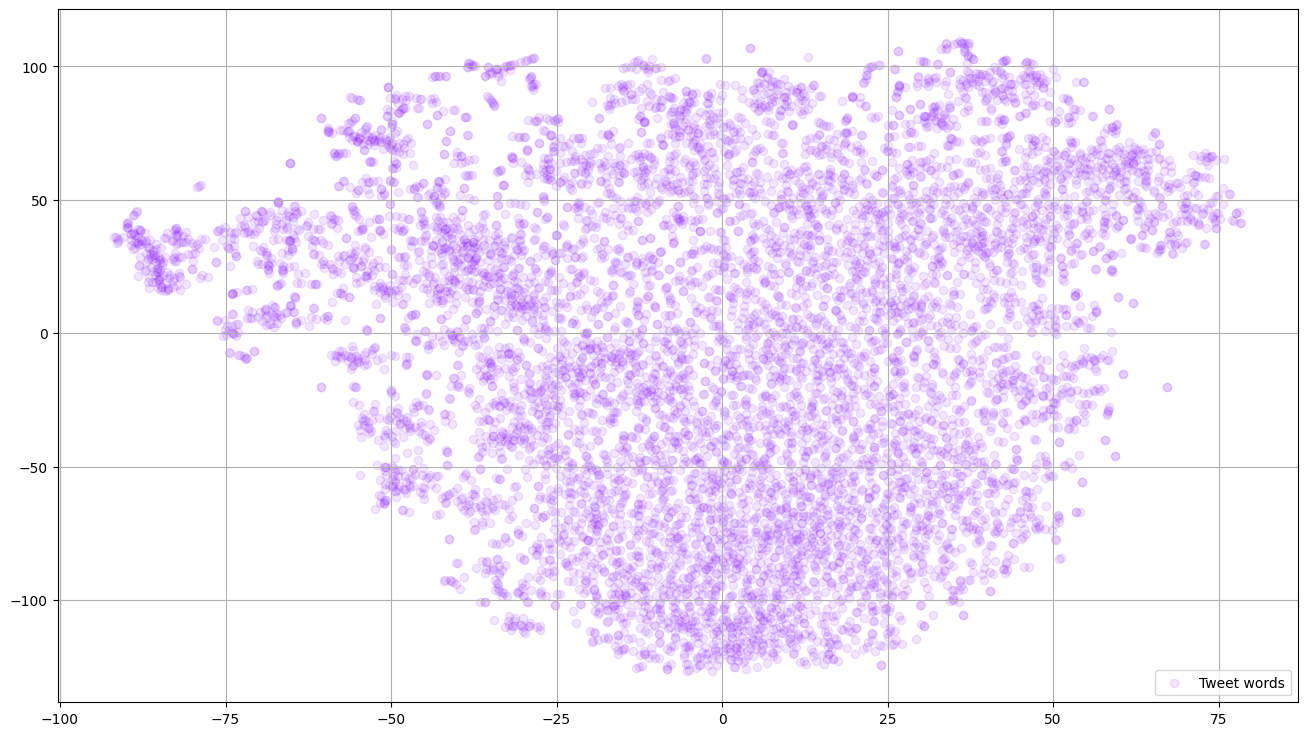

In [49]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('Tweet words', embeddings_ak_2d, a=0.1)

## Evaluation

Load evaluation.csv and Parse the Ground Truth:

In [46]:
evaluation_df = pd.read_csv("data/evaluation.csv", sep=";")
evaluation_df.head()

,docId,query_id,label
0,doc_156,1.0,0.0
1,doc_1039,1.0,0.0
2,doc_1047,1.0,1.0
3,doc_1685,1.0,0.0
4,doc_2100,1.0,1.0


In [67]:
ground_truth = evaluation_df[evaluation_df['label'] == 1].groupby('query_id')['docId'].apply(set).to_dict()
print(ground_truth)

{1.0: {'doc_4053', 'doc_5751', 'doc_5480', 'doc_5512', 'doc_8066', 'doc_9937', 'doc_6477', 'doc_9850', 'doc_1047', 'doc_3474', 'doc_2100', 'doc_9696', 'doc_3570', 'doc_10048', 'doc_3287'}, 2.0: {'doc_3682', 'doc_3116', 'doc_4304', 'doc_1666', 'doc_2653', 'doc_2528', 'doc_103', 'doc_3646', 'doc_1785', 'doc_3076', 'doc_4176', 'doc_1651', 'doc_1566', 'doc_3927', 'doc_3005'}}


In [47]:
print_result = evaluation_df["label"].unique() # label is doc_score (1 or 0)
print_result = [x for x in print_result if str(x) != 'nan']
print("The ground truth of our dataset is composed of {} Relevance labels: {}".format(len(print_result), sorted(print_result)))

The ground truth of our dataset is composed of 2 Relevance labels: [0.0, 1.0]


In [104]:
test_queries = {
    1: "what are the people's rights?",
    2: "what is being said about the Indian government?"
}

what are the people's rights?


In [161]:
relevant_docs_query_1 = set(ground_truth[1])
retrieved_docs_query_1 = set(search_tf_idf(test_queries[1], index))
relevant_docs_query_2 = set(ground_truth[2])
retrieved_docs_query_2 = set(search_tf_idf(test_queries[2], index))
common_docs_query_1 = relevant_docs_query_1.intersection(retrieved_docs_query_1)
common_docs_query_2 = relevant_docs_query_2.intersection(retrieved_docs_query_2)

print("Common documents for query 1: ", len(common_docs_query_1))
print("Common documents for query 2: ", len(common_docs_query_2)) # 0 common documents :(

# as 0 common docs for query 2 -> we need to improve the search engine
# for "indian goverment" we get lots of documents (>500) but for query 2 we get only 3

Common documents for query 1:  14
Common documents for query 2:  0


#### Precioson@K (P@K)

In [122]:
def precision_at_k(relevant_docs, retrieved_docs, k):
    top_k_docs = list(retrieved_docs)[:k]
    relevant_docs_in_top_k = sum(1 for doc in top_k_docs if doc in relevant_docs)
    precision = relevant_docs_in_top_k / k
    return precision

In [131]:
# Precision@150 for query 1
print("# Relevant docs for query 1: ", len(relevant_docs_query_1))
print("# Retrieved docs for query 1: ", len(retrieved_docs_query_1))
precision_at_150_query_1 = precision_at_k(relevant_docs_query_1, retrieved_docs_query_1,150)
print("# Common docs for query 1: ", len(common_docs_query_1))
print("Precision@150 for query 1:", precision_at_150_query_1)

# Relevant docs for query 1:  15
# Retrieved docs for query 1:  327
# Common docs for query 1:  14
Precision@150 for query 1: 0.04


In [132]:
# Precision@150 for query 2
print("# Relevant docs for query 2: ", len(relevant_docs_query_2))
print("# Retrieved docs for query 2: ", len(retrieved_docs_query_2))
precision_at_150_query_2 = precision_at_k(relevant_docs_query_2, retrieved_docs_query_2, 150)
print("# Common docs for query 2: ", len(common_docs_query_2))
print("Precision@150 for query 2:", precision_at_150_query_2)

# Relevant docs for query 2:  15
# Retrieved docs for query 2:  3
# Common docs for query 2:  0
Precision@150 for query 2: 0.0


#### Recall@K (R@K)

In [134]:
def recall_at_k(relevant_docs, retrieved_docs, k):
    top_k_docs = list(retrieved_docs)[:k]
    relevant_docs_in_top_k = sum(1 for doc in top_k_docs if doc in relevant_docs)
    recall = relevant_docs_in_top_k / len(relevant_docs)
    return recall

In [136]:
recall_at_150_query_1 = recall_at_k(relevant_docs_query_1, retrieved_docs_query_1, 150)
print("Recall@150 for query 1:", recall_at_150_query_1)

recall_at_150_query_2 = recall_at_k(relevant_docs_query_2, retrieved_docs_query_2, 150)
print("Recall@150 for query 2:", recall_at_150_query_2)

Recall@150 for query 1: 0.4
Recall@150 for query 2: 0.0


#### Average Precision@K 

In [141]:
def average_precision_at_k(relevant_docs, retrieved_docs, k):
    retrieved_docs = list(retrieved_docs)

    precision_sum = 0.0
    relevant_count = 0
    
    # iterate through the top k retrieved documents
    for i in range(min(k, len(retrieved_docs))):
        if retrieved_docs[i] in relevant_docs:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)  # i + 1 because index is 0-based
            precision_sum += precision_at_i

    # calculate average precision
    if relevant_count > 0:
        average_precision = precision_sum / relevant_count
    else:
        average_precision = 0.0

    return average_precision

In [143]:
average_precision_at_150_query_1 = average_precision_at_k(relevant_docs_query_1, retrieved_docs_query_1, 150)
print("Average Precision@150 for query 1:", average_precision_at_150_query_1)

average_precision_at_150_query_2 = average_precision_at_k(relevant_docs_query_2, retrieved_docs_query_2, 150)
print("Average Precision@150 for query 2:", average_precision_at_150_query_2)

Average Precision@150 for query 1: 0.04888158489948199
Average Precision@150 for query 2: 0.0


#### F1-Score@K

In [147]:
def f1_score_at_k(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [148]:
f1_score_at_150_query_1 = f1_score_at_k(precision_at_150_query_1, recall_at_150_query_1)
print("F1 Score@150 for query 1:", f1_score_at_150_query_1)

f1_score_at_150_query_2 = f1_score_at_k(precision_at_150_query_2, recall_at_150_query_2)
print("F1 Score@150 for query 2:", f1_score_at_150_query_2)

F1 Score@150 for query 1: 0.07272727272727272
F1 Score@150 for query 2: 0


#### Mean Average Precision (MAP)

In [150]:
def mean_average_precision(queries, relevant_docs_dict, retrieved_docs_dict, k):
    average_precisions = []

    for query in queries:
        relevant_docs = relevant_docs_dict.get(query, set())
        retrieved_docs = retrieved_docs_dict.get(query, [])

        avg_precision = average_precision_at_k(relevant_docs, retrieved_docs, k)
        average_precisions.append(avg_precision)

    # calculate MAP
    mean_avg_precision = sum(average_precisions) / len(average_precisions) if average_precisions else 0.0

    return mean_avg_precision

In [152]:
relevant_docs_dict = {
    1: relevant_docs_query_1,
    2: relevant_docs_query_2
}

retrieved_docs_dict = {
    1: retrieved_docs_query_1,
    2: retrieved_docs_query_2
}

map_150 = mean_average_precision(test_queries.keys(), relevant_docs_dict, retrieved_docs_dict, 150)
print("MAP@150 for the test queries:", map_150)

MAP@150 for the test queries: 0.024440792449740994


#### Mean Reciprocal Rank (MRR)

In [153]:
def reciprocal_rank(queries, relevant_docs_dict, retrieved_docs_dict):
    reciprocal_ranks = []

    for query in queries:
        relevant_docs = relevant_docs_dict.get(query, set())
        retrieved_docs = retrieved_docs_dict.get(query, [])

        # find the rank of the first relevant document
        for rank, doc in enumerate(retrieved_docs, start=1):
            if doc in relevant_docs:
                reciprocal_ranks.append(1 / rank)
                break
        else:
            reciprocal_ranks.append(0)

    # calculate MRR
    mean_reciprocal_rank_value = sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0.0

    return mean_reciprocal_rank_value


In [155]:
mrr = reciprocal_rank(test_queries.keys(), relevant_docs_dict, retrieved_docs_dict)
print("MRR for the test queries:", mrr)

MRR for the test queries: 0.045454545454545456


#### Normalized Discounted Cumulative Gain (NDCG)

In [156]:
def dcg(relevance_scores):
    return sum(relevance / np.log2(idx + 1) for idx, relevance in enumerate(relevance_scores, start=1))

def ndcg(relevant_docs, retrieved_docs):
    sorted_relevant_docs = sorted(relevant_docs, key=lambda x: x[1], reverse=True)
    
    # create relevance scores for the retrieved documents
    relevance_scores = [0] * len(retrieved_docs)
    for idx, doc_id in enumerate(retrieved_docs):
        for relevant_doc in sorted_relevant_docs:
            if doc_id == relevant_doc[0]:
                relevance_scores[idx] = relevant_doc[1]  # set the relevance score for this doc
                break

    # calculate DCG for retrieved documents
    dcg_score = dcg(relevance_scores)

    # calculate IDCG for ideal ranking
    ideal_relevance_scores = [relevance for _, relevance in sorted_relevant_docs]
    idcg_score = dcg(ideal_relevance_scores)

    # calculate NDCG
    ndcg_score = dcg_score / idcg_score if idcg_score > 0 else 0.0

    return ndcg_score

In [160]:
ndcg_query_1 = ndcg([(doc, 1) for doc in relevant_docs_query_1], retrieved_docs_query_1)
print("NDCG for query 1:", ndcg_query_1)

ndcg_query_2 = ndcg([(doc, 1) for doc in relevant_docs_query_2], retrieved_docs_query_2)
print("NDCG for query 2:", ndcg_query_2)

NDCG for query 1: 0.3529844301084985
NDCG for query 2: 0.0
